### Load data

In [2]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
df = spark.table('df_model_final')
df.show(5)

+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+
 uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|device_type|
+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+
121612724 | 1| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 3| 0|
 125027545| 1| 0| 0| 0| 0| 3| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 1|
 125227372| 0| 60| 63| 63| 63| 63| 0| 7| 17| 17| 17| 0| 0| 0| 0| 0| 2|
 128035483| 0| 53| 141| 143| 143| 143| 0| 2| 3| 3| 3| 1| 1| 3| 3| 3| 2|
 129429838| 0| 2| 17| 305| 570| 914| 0| 3| 19| 35| 60| 0| 3| 37| 51| 94| 2|
+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+
only showing top 5 rows

In [4]:
df

Out[ 3 ]: DataFrame[uid: string, label: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint, device_type: int]

### Prepare training data

In [6]:
type(df.columns)

Out[ 8 ]: list

In [7]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

Out[ 7 ]: 
['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30']

In [8]:
# training data
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df)

#For VectorAssembler, refer to https://spark.apache.org/docs/latest/ml-features.html#vectorassembler

# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

In [9]:
selected_features

Out[ 16 ]: 
['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30']

In [10]:
data.select('features').show(5)
#What does those notations mean?

+--------------------+
 features|
+--------------------+
 (15,[14],[3.0])|
 (15,[4],[3.0])|
[60.0,63.0,63.0,6...|
[53.0,141.0,143.0...|
[2.0,17.0,305.0,5...|
+--------------------+
only showing top 5 rows

In [11]:
#Convert to pandas for better understanding
a=data.select('features').toPandas()

In [12]:
#seems alright now
a

Out[ 23 ]: 
 features
0 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1 (0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...
2 [60.0, 63.0, 63.0, 63.0, 63.0, 0.0, 7.0, 17.0,...
3 [53.0, 141.0, 143.0, 143.0, 143.0, 0.0, 2.0, 3...
4 [2.0, 17.0, 305.0, 570.0, 914.0, 0.0, 3.0, 19....
5 [0.0, 0.0, 369.0, 392.0, 1201.0, 0.0, 0.0, 1.0...
6 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
7 (0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0,...
8 [8.0, 43.0, 149.0, 292.0, 689.0, 0.0, 0.0, 7.0...
9 (0.0, 0.0, 0.0, 1.0, 138.0, 0.0, 0.0, 0.0, 0.0...
10 (22.0, 61.0, 72.0, 242.0, 242.0, 0.0, 0.0, 0.0...
11 (0.0, 0.0, 0.0, 0.0, 69.0, 0.0, 0.0, 0.0, 0.0,...
12 (0.0, 0.0, 0.0, 0.0, 391.0, 0.0, 0.0, 0.0, 0.0...
13 [19.0, 33.0, 60.0, 101.0, 232.0, 0.0, 0.0, 0.0...
14 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
15 (0.0, 5.0, 5.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, ...
16 [2.0, 7.0, 41.0, 82.0, 252.0, 0.0, 2.0, 2.0, 1...
17 (0.0, 0.0, 1.0, 277.0, 613.0, 0.0, 0.0, 0.0, 0...
18 (0.0, 0.0, 0.0, 0.0, 77.0, 0.0, 0.0, 0.0, 0.0,...
19 (0.0, 3.0, 3.0, 3.0, 14.0, 0.0, 0.0, 0.0, 0.0,...
20 (0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, ...
21 [7.0, 7.0, 92.0, 291.0, 582.0, 0.0, 0.0, 0.0, ...
22 (0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
23 (0.0, 0.0, 0.0, 1.0, 10.0, 0.0, 0.0, 0.0, 0.0,...
24 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
25 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
26 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
27 (0.0, 0.0, 0.0, 2.0, 186.0, 0.0, 0.0, 0.0, 0.0...
28 (0.0, 3.0, 5.0, 5.0, 89.0, 0.0, 0.0, 0.0, 0.0,...
29 (0.0, 0.0, 0.0, 0.0, 97.0, 0.0, 0.0, 0.0, 0.0,...
... ...
664000 (0.0, 12.0, 69.0, 104.0, 349.0, 0.0, 0.0, 0.0,...
664001 (0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0,...
664002 (0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...
664003 (0.0, 0.0, 0.0, 5.0, 352.0, 0.0, 0.0, 0.0, 0.0...
664004 (0.0, 0.0, 0.0, 0.0, 95.0, 0.0, 0.0, 0.0, 0.0,...
664005 (0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...
664006 (0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0,...
664007 (0.0, 0.0, 0.0, 0.0, 55.0, 0.0, 0.0, 0.0, 0.0,...
664008 (0.0, 0.0, 19.0, 35.0, 274.0, 0.0, 0.0, 0.0, 0...
664009 [17.0, 25.0, 35.0, 38.0, 107.0, 0.0, 1.0, 2.0,...
664010 [6.0, 61.0, 133.0, 161.0, 371.0, 0.0, 0.0, 3.0...
664011 (0.0, 2.0, 43.0, 46.0, 501.0, 0.0, 0.0, 0.0, 0...
664012 (0.0, 0.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0,...
664013 (0.0, 0.0, 100.0, 139.0, 139.0, 0.0, 0.0, 0.0,...
664014 (0.0, 0.0, 0.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...
664015 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
664016 (38.0, 72.0, 173.0, 360.0, 1066.0, 0.0, 0.0, 0...
664017 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
664018 [33.0, 33.0, 117.0, 290.0, 534.0, 0.0, 0.0, 2....
664019 (0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...
664020 (0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0,...
664021 [95.0, 253.0, 459.0, 970.0, 1790.0, 8.0, 8.0, ...
664022 (0.0, 0.0, 0.0, 0.0, 67.0, 0.0, 0.0, 0.0, 0.0,...
664023 (0.0, 0.0, 4.0, 34.0, 110.0, 0.0, 0.0, 0.0, 1....
664024 (0.0, 23.0, 30.0, 152.0, 178.0, 0.0, 0.0, 0.0,...
664025 (0.0, 2.0, 2.0, 6.0, 36.0, 0.0, 0.0, 0.0, 0.0,...
664026 [6.0, 62.0, 93.0, 348.0, 1418.0, 0.0, 0.0, 1.0...
664027 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
664028 (0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0,...
664029 (0.0, 0.0, 0.0, 72.0, 146.0, 0.0, 0.0, 0.0, 0....

[664030 rows x 1 columns]

In [13]:
#however the notation in pyspark dataframe is different
data.select('features').head(5)

Out[ 26 ]: 
[Row(features=SparseVector(15, {14: 3.0})),
 Row(features=SparseVector(15, {4: 3.0})),
 Row(features=DenseVector([60.0, 63.0, 63.0, 63.0, 63.0, 0.0, 7.0, 17.0, 17.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0])),
 Row(features=DenseVector([53.0, 141.0, 143.0, 143.0, 143.0, 0.0, 2.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0])),
 Row(features=DenseVector([2.0, 17.0, 305.0, 570.0, 914.0, 0.0, 3.0, 19.0, 35.0, 60.0, 0.0, 3.0, 37.0, 51.0, 94.0]))]

In [14]:
data.show(5)

+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+--------------------+
 uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|device_type| features|
+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+--------------------+
121612724 | 1| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 3| 0| (15,[14],[3.0])|
 125027545| 1| 0| 0| 0| 0| 3| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 1| (15,[4],[3.0])|
 125227372| 0| 60| 63| 63| 63| 63| 0| 7| 17| 17| 17| 0| 0| 0| 0| 0| 2|[60.0,63.0,63.0,6...|
 128035483| 0| 53| 141| 143| 143| 143| 0| 2| 3| 3| 3| 1| 1| 3| 3| 3| 2|[53.0,141.0,143.0...|
 129429838| 0| 2| 17| 305| 570| 914| 0| 3| 19| 35| 60| 0| 3| 37| 51| 94| 2|[2.0,17.0,305.0,5...|
+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+--------------------+
only showing top 5 rows

### Fit logistic regression

In [16]:
#Documentation: http://spark.apache.org/docs/2.2.2/api/java/org/apache/spark/ml/classification/LogisticRegression.html
ml = LogisticRegression(maxIter=3, regParam=0.01)
#set max iteration and regularization parameter
model = ml.fit(train)

In [17]:
type(model)

Out[ 29 ]: pyspark.ml.classification.LogisticRegressionModel

### Predict and Evaluate performance

In [19]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()


+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.21286015373854...| 1.0| 1| (15,[4],[9.0])|
[0.99594898631847...| 0.0| 0|(15,[1,2,3,4],[15...|
[0.21174356418932...| 1.0| 1| (15,[4],[4.0])|
[0.21295282331247...| 1.0| 1| (15,[14],[2.0])|
[0.29305969708754...| 1.0| 0|(15,[4,9],[328.0,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.22151629152654...| 1.0| 1|(15,[4,9,14],[28....|
[0.37641083783323...| 1.0| 1|(15,[3,4,8,9],[83...|
[0.21107566960644...| 1.0| 1| (15,[4],[1.0])|
[0.21542717621593...| 1.0| 1|(15,[4,9,14],[6.0...|
[0.22263983207587...| 1.0| 1| (15,[4],[52.0])|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

In [20]:
predictions_train.show(5)

+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+--------------------+--------------------+--------------------+----------+
 uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|device_type| features| rawPrediction| probability|prediction|
+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+--------------------+--------------------+--------------------+----------+
 100071797| 1| 0| 0| 0| 0| 9| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 2| (15,[4],[9.0])|[-1.3077705331436...|[0.21286015373854...| 1.0|
 100087237| 0| 0| 154| 297| 613| 810| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 2|(15,[1,2,3,4],[15...|[5.50472889618245...|[0.99594898631847...| 0.0|
 100107633| 1| 0| 0| 0| 0| 4| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 2| (15,[4],[4.0])|[-1.3144475234425...|[0.21174356418932...| 1.0|
100549339 | 1| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 2| 0| (15,[14],[2.0])|[-1.3072175372041...|[0.21295282331247...| 1.0|
 101372876| 0| 0| 0| 0| 0| 328| 0| 0| 0| 0| 3| 0| 0| 0| 0| 0| 2|(15,[4,9],[328.0,...|[-0.8805698925596...|[0.29305969708754...| 1.0|
+----------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

### Evaluate performance

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
# false positive rate, true positive rate
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    display()
    

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

In [23]:
res_train

Out[ 35 ]: 
 probability label
0 [0.212860153739, 0.787139846261] 1
1 [0.995948986318, 0.00405101368152] 0
2 [0.211743564189, 0.788256435811] 1
3 [0.212952823312, 0.787047176688] 1
4 [0.293059697088, 0.706940302912] 0
5 [0.651474313733, 0.348525686267] 0
6 [0.222658155507, 0.777341844493] 1
7 [0.226466777806, 0.773533222194] 1
8 [0.459193745545, 0.540806254455] 0
9 [0.223926863672, 0.776073136328] 0
10 [0.213083986424, 0.786916013576] 1
11 [0.674089317532, 0.325910682468] 0
12 [0.999999999987, 1.34158725834e-11] 0
13 [0.211901201329, 0.788098798671] 1
14 [0.217197325058, 0.782802674942] 1
15 [0.345230376165, 0.654769623835] 1
16 [0.210987488492, 0.789012511508] 1
17 [0.392952364179, 0.607047635821] 0
18 [0.213692620135, 0.786307379865] 1
19 [0.217398799419, 0.782601200581] 1
20 [0.33795631647, 0.66204368353] 0
21 [0.211298129537, 0.788701870463] 1
22 [0.366916892958, 0.633083107042] 0
23 [0.938471749122, 0.0615282508776] 0
24 [0.262823792349, 0.737176207651] 0
25 [0.958764422388, 0.0412355776117] 1
26 [0.214976988065, 0.785023011935] 0
27 [0.211520761065, 0.788479238935] 1
28 [0.211075669606, 0.788924330394] 1
29 [0.448465371001, 0.551534628999] 0
... ... ...
464539 [0.211298129537, 0.788701870463] 1
464540 [0.212636492642, 0.787363507358] 1
464541 [0.210920427073, 0.789079572927] 1
464542 [0.476916819117, 0.523083180883] 0
464543 [0.963306692879, 0.0366933071213] 0
464544 [0.228609012284, 0.771390987716] 1
464545 [0.518593175753, 0.481406824247] 0
464546 [0.314799038327, 0.685200961673] 0
464547 [0.741595026656, 0.258404973344] 0
464548 [0.211075669606, 0.788924330394] 0
464549 [0.97062737191, 0.0293726280898] 1
464550 [0.975472064512, 0.0245279354881] 1
464551 [0.999946136447, 5.38635530761e-05] 0
464552 [0.2254576851, 0.7745423149] 0
464553 [0.989829336517, 0.0101706634829] 0
464554 [0.992459558991, 0.00754044100892] 0
464555 [0.220569741791, 0.779430258209] 1
464556 [0.214008247064, 0.785991752936] 1
464557 [0.298860707737, 0.701139292263] 0
464558 [0.311216557589, 0.688783442411] 1
464559 [0.212860153739, 0.787139846261] 1
464560 [0.999999916289, 8.37111258364e-08] 0
464561 [0.573421109837, 0.426578890163] 0
464562 [0.212124297377, 0.787875702623] 1
464563 [0.211968490815, 0.788031509185] 1
464564 [0.920422287088, 0.079577712912] 0
464565 [0.629906686562, 0.370093313438] 0
464566 [0.350530053449, 0.649469946551] 0
464567 [0.245860176912, 0.754139823088] 1
464568 [0.212191638633, 0.787808361367] 0

[464569 rows x 2 columns]

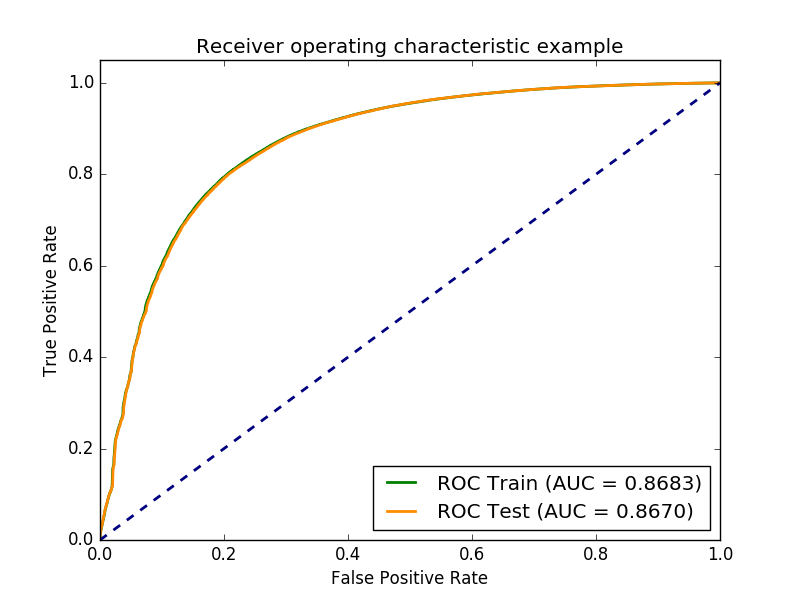

In [24]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Let's train random forest too!

In [26]:
ml = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,numTrees=50#50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=12#20
                            ,minInstancesPerNode=10
                            ,maxBins=16
                            )
model = ml.fit(train)

In [27]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.08507294664457...| 1.0| 1| (15,[4],[9.0])|
[0.84285079681885...| 0.0| 0|(15,[1,2,3,4],[15...|
[0.08520878587325...| 1.0| 1| (15,[4],[4.0])|
[0.03333244174403...| 1.0| 1| (15,[14],[2.0])|
[0.14699863859189...| 1.0| 0|(15,[4,9],[328.0,...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.13923118585937...| 1.0| 1|(15,[4,9,14],[28....|
[0.41209683061111...| 1.0| 1|(15,[3,4,8,9],[83...|
[0.06816407743986...| 1.0| 1| (15,[4],[1.0])|
[0.10582950708897...| 1.0| 1|(15,[4,9,14],[6.0...|
[0.09463388667179...| 1.0| 1| (15,[4],[52.0])|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

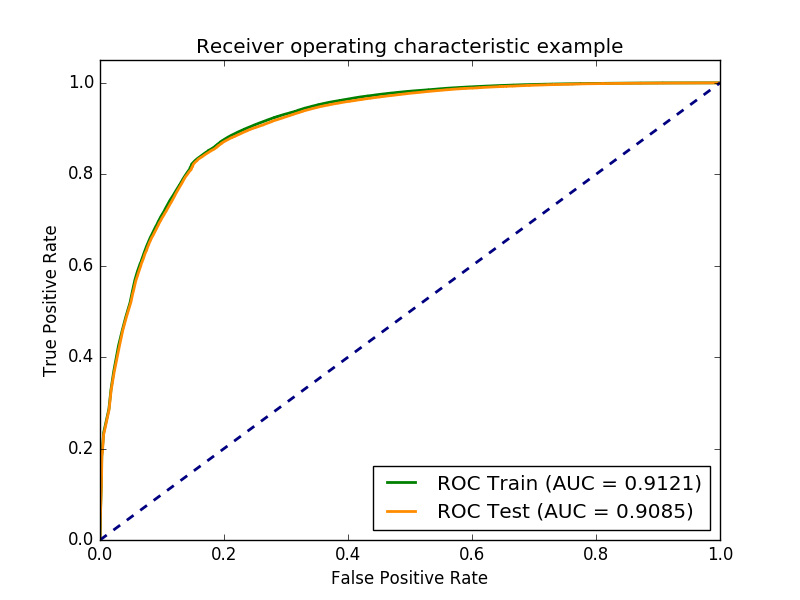

In [28]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)